In [42]:
import os
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoModelForMaskedLM, AutoTokenizer, DefaultDataCollator

In [43]:
model_path = 'kuleshov-group/PlantCaduceus_l20'
device = "cuda"
model = AutoModelForMaskedLM.from_pretrained(model_path, trust_remote_code=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

In [44]:
model.eval()

CaduceusForMaskedLM(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(8, 384)
        )
      )
      (layers): ModuleList(
        (0-19): 20 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=384, out_features=1536, bias=False)
                (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
                (act): SiLU()
                (x_proj): Linear(in_features=768, out_features=56, bias=False)
                (dt_proj): Linear(in_features=24, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=384, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=384, out_features=1536, bias=False)
                (conv1

In [45]:
## Visualization functions

import seaborn as sns
import matplotlib.pyplot as plt

def plot_map_with_seq(matrix, dna_sequence,  plot_size=10, vmax=5, tick_label_fontsize=8):

    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
   
    sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, ax=ax, 
                xticklabels=False, yticklabels=False)  
    ax.set_aspect('equal')

    tick_positions = np.arange(len(dna_sequence)) + 0.5 # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()
    
def plot_map(matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):
   
    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size})

    ax.set_aspect('equal')

    plt.show()

In [ ]:
nuc_table = {"a" : 0, "c":1, "g":2, "t":3}

def mutate_sequence(seq):
    
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['a', 'c', 'g', 't']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def tok_func(seq):
    return tokenizer.encode_plus(seq, 
                                return_tensors='pt',
                                return_attention_mask=False, 
                                return_token_type_ids=False,
                                add_special_tokens=True)


def create_dataloader(dataset, batch_size=64):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(lambda x: tok_func(x['seq']), batched=False,  num_proc=4)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, 
                                              batch_size=batch_size, 
                                              num_workers=4, 
                                              shuffle=False, 
                                              collate_fn=data_collator)

    return data_loader

acgt_idxs = tokenizer.convert_tokens_to_ids(['a', 'c', 'g', 't'])

def model_inference(model, dataloader):
    output_array = []
    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device).squeeze(1)
        with torch.no_grad():
            outputs = model(input_ids=input_ids)
            logits = outputs.logits.cpu().to(torch.float32)
          #  print(f"Logits values: min {logits.min()}, max {logits.max()}, mean {logits.mean()}")
        output_probs = torch.nn.functional.softmax(logits, dim=-1)[:,:,acgt_idxs]
        output_array.append(output_probs)

    snp_reconstruct = torch.concat(output_array, axis=0)
    print(f"SNP Reconstruct values: min {snp_reconstruct.min()}, max {snp_reconstruct.max()}, mean {snp_reconstruct.mean()}")
    return snp_reconstruct.to(torch.float32).numpy()

def compute_dependency_map(seq, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset)
    snp_reconstruct = model_inference(model, data_loader)
     # for the logit add a small value epsilon and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]
   # print(f"Reference Prob values: min {reference_probs.min()}, max {reference_probs.max()}, mean {reference_probs.mean()}")
    
    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)
    #print(f"SNP Effect values: min {snp_effect.min()}, max {snp_effect.max()}, mean {snp_effect.mean()}")
    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    #zero main diagonal values
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0
    print(f"Dep Map values: min {dep_map.min()}, max {dep_map.max()}, mean {dep_map.mean()}")

    return dep_map


In [ ]:
seq = "GTGTATTTCTAGAGGCGATTTGTCATTTCCCGAATAGGAATTTGAGTAAAAAAAAACACTCTGTTTTTTATTTCCACTAATATCAAATCGGCGAATATAGTTCCCACCATTCTTATCTCCTTGTCGTCACTCGGAATTTTTTAAATAATAGGATCGCTTTAATAATATAATCTCTATAATTTATAGTTCCTTTTCCAATATTGGCGTCTCCGTTGAAGCTTTCCACAAATCTCAAATTTGTTTGGAGACTCTCAAATGTATCCTTCTCTCGACGATGATTTCGTCTCTGATTTGTTTTGCTTCGATCAAAGGTTCGTCCTTTCGCACTCTTCTCTTCCTTCACCTTCCTCTGTTTTCTCTATCTCTTTCGATTCAGTTGTTTTATCGAATTTGATCCCTTTTTTCAATTGCAAAATCATATCTTTAATGTTCAATTCGATTTCTGTGAAAAGTGTTGTTGTTTTTTTCGCATTTCAGGGGGAAAGGTTGTGTCTTTTGATGATAATTTGACG".replace('U','T').lower()

In [103]:
dep_map = compute_dependency_map(seq)

Map (num_proc=4): 100%|██████████| 3010/3010 [00:01<00:00, 2325.09 examples/s]


Logits values: min -28.25243377685547, max 4.941232681274414, mean -11.253090858459473
Logits values: min -28.69320297241211, max 4.950575351715088, mean -11.25190258026123
Logits values: min -28.59515380859375, max 4.941466331481934, mean -11.251619338989258
Logits values: min -29.0010929107666, max 4.941744327545166, mean -11.253085136413574
Logits values: min -28.745098114013672, max 4.9393439292907715, mean -11.257817268371582
Logits values: min -28.536651611328125, max 4.95338249206543, mean -11.246662139892578
Logits values: min -28.4676570892334, max 4.945346355438232, mean -11.246187210083008
Logits values: min -28.121192932128906, max 4.947030544281006, mean -11.25341510772705
Logits values: min -28.163612365722656, max 4.9504923820495605, mean -11.251126289367676
Logits values: min -28.128812789916992, max 4.952167510986328, mean -11.25101375579834
Logits values: min -28.161405563354492, max 4.948895454406738, mean -11.251667022705078
Logits values: min -28.154436111450195, m

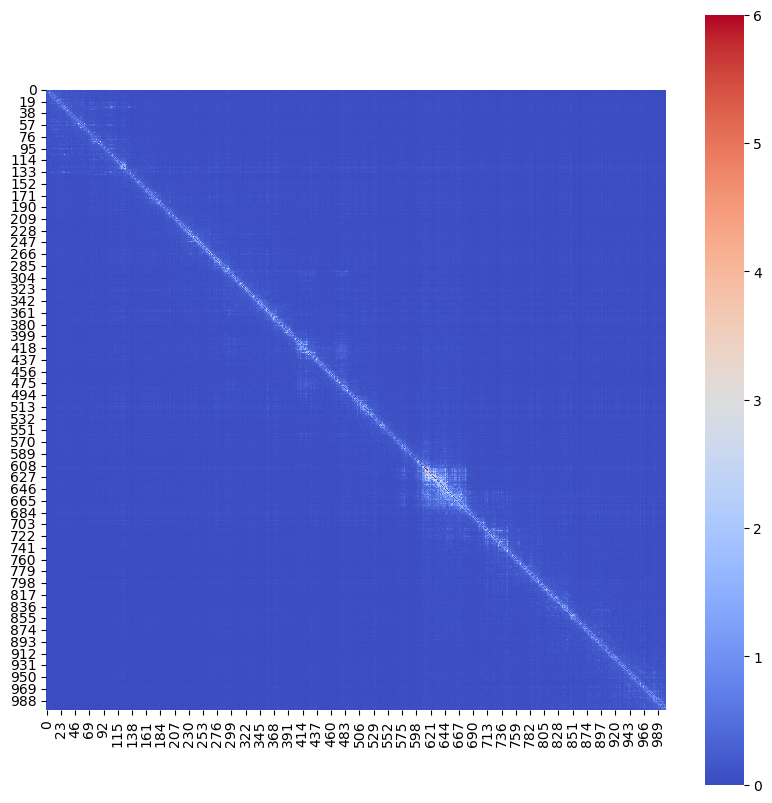

In [ ]:
plot_map(dep_map, vmax=4)

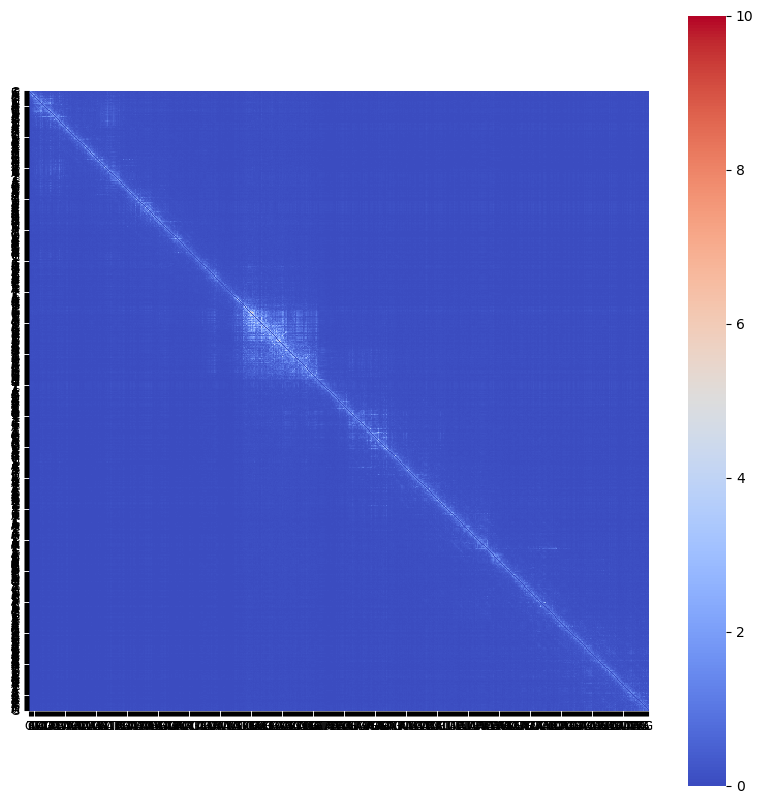

In [108]:
plot_map_with_seq(dep_map[400:1000,400:1000],  seq[400: 1000], vmax=10, tick_label_fontsize=8.5)

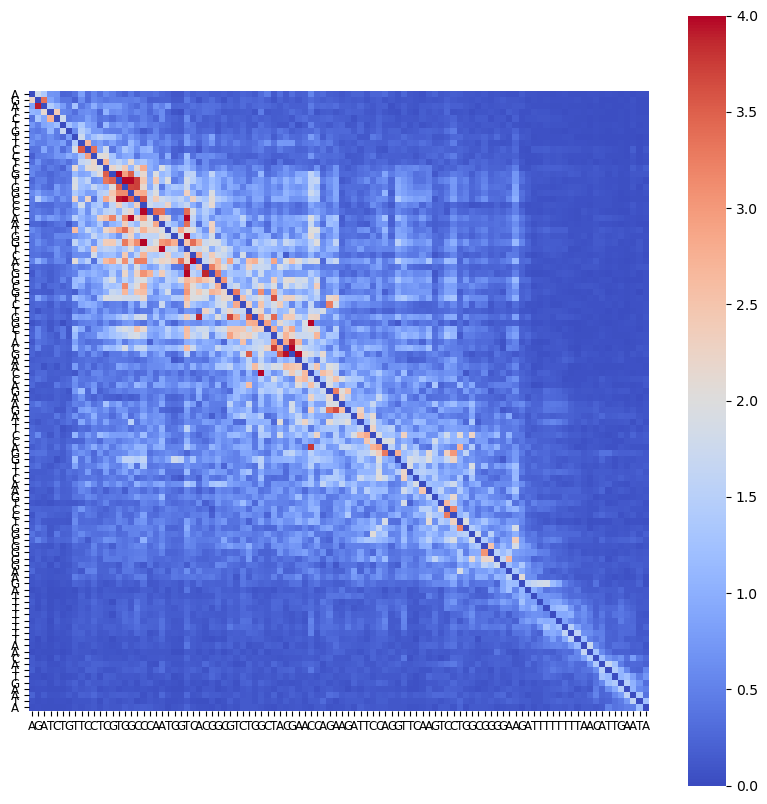

In [112]:
x, y = 600, 700
plot_map_with_seq(dep_map[x:y,x:y],  seq[x:y], vmax=4, tick_label_fontsize=8.5)

In [113]:
#sequence 1kb 5' of the start codon of SMT3 in S. cerevisiae
SMT3_five_prime_seq = 'GCTTCCCTCATTATTCCGCCCATGGCGTCTATTACCAAGCGTCATAATGTGCAATATTTGATATTATATAAGCTACTTGAGAAAGCGATAGTTTTTTTTTCTTACACAAAAAAAAAAAAACATAAAGCACCTATAACTCTCAACTTTGAAGAAGCACGAAAGGAATATGTTTAAATCAACAGAAATGTGAAAAAAATCGGTTATATATACAGAATCCGATTCTTTCTAACATCAAAGAGGTGGGGGAAGAAGGGACTCAAAAAAGAAACGACACTGCACAACCCGAGCCAAACTGACATACGAACACTAAAACCGATTTCCGAAAAAAACTTCAAATTTACATTTCATTGTCCGTCTGCCATCGCATCATCGCCTTCATCTCTAAGAGTTGCCGTGCCTTTCCATCCGCTTTCTTTTCATGCGGCGTTATTCTTTTTTCCTATTTTTGATGGTCCCTGTGCCGTTTCTTTTTCATGTTCACCGGTTTTTGGCGCCGCATACCGTACGGCGGGGCACTTTTGAAACGTTTTTGTGCATCCTGATGCCGTTTTCAAGGATCGCAAGCACGTCGCATAATACGGTAATGCCGAATTAAGGCTACGTCGTCATAGTAGGTTAGTCATGCGCGTTGGAAAAAGAAATGACCAACGCGTTGATTACGTAGTCCCCAAGGAATAATGCTTTTGAAAGTGAAAAAAAAAAATAAAACTGAAAAAAGCCATGCTGTTTCCATCACGTGCATGTCACGTTTTTGCCGCCGAACTCTTTGATCATGTGATATGAATATGTTGGGTTACCCAGCTTTGCCAACACGCGCCGTCGGAAGGTGTTCAGGAAGCAGGAAAAGAGCAAAACACCAACAATCAAACAAACGAACACATTCTACTCTTTTAGTTGATTTTTCTTACCTTTTCCAAGCTCCCGTTTCTTGTTACCACCTGTAGCATATAGGACAGAAGGACCCAGTTCAGTTCTAGTTTTACAAATAAATACACGAGCGATG'

In [114]:
dep_map = compute_dependency_map(SMT3_five_prime_seq)

Map (num_proc=4): 100%|██████████| 3010/3010 [00:01<00:00, 2422.56 examples/s]


Logits values: min -28.61260223388672, max 2.163071393966675, mean -11.18606948852539
Logits values: min -28.61455726623535, max 2.1264395713806152, mean -11.183231353759766
Logits values: min -28.65589141845703, max 2.1360268592834473, mean -11.184739112854004
Logits values: min -28.619678497314453, max 2.1665921211242676, mean -11.180588722229004
Logits values: min -28.629985809326172, max 2.2371413707733154, mean -11.174934387207031
Logits values: min -28.61345672607422, max 2.1790194511413574, mean -11.167471885681152
Logits values: min -28.646953582763672, max 2.1793837547302246, mean -11.196622848510742
Logits values: min -28.618268966674805, max 2.1182913780212402, mean -11.188072204589844
Logits values: min -28.61090087890625, max 2.1203556060791016, mean -11.185112953186035
Logits values: min -28.635374069213867, max 2.113651990890503, mean -11.173807144165039
Logits values: min -28.652889251708984, max 2.137407064437866, mean -11.18431282043457
Logits values: min -28.64212608

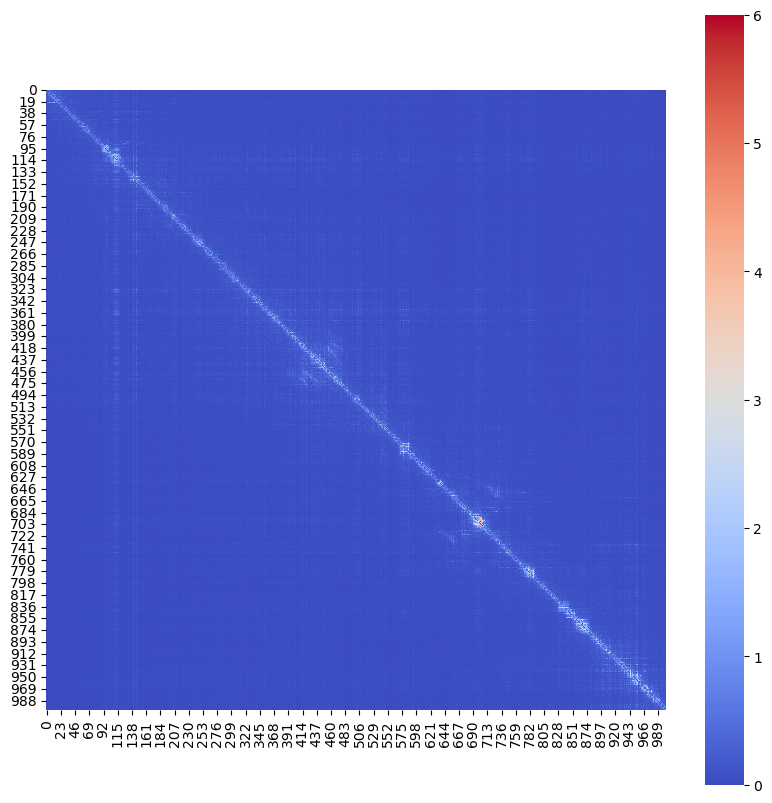

In [116]:
plot_map(dep_map, vmax=6)

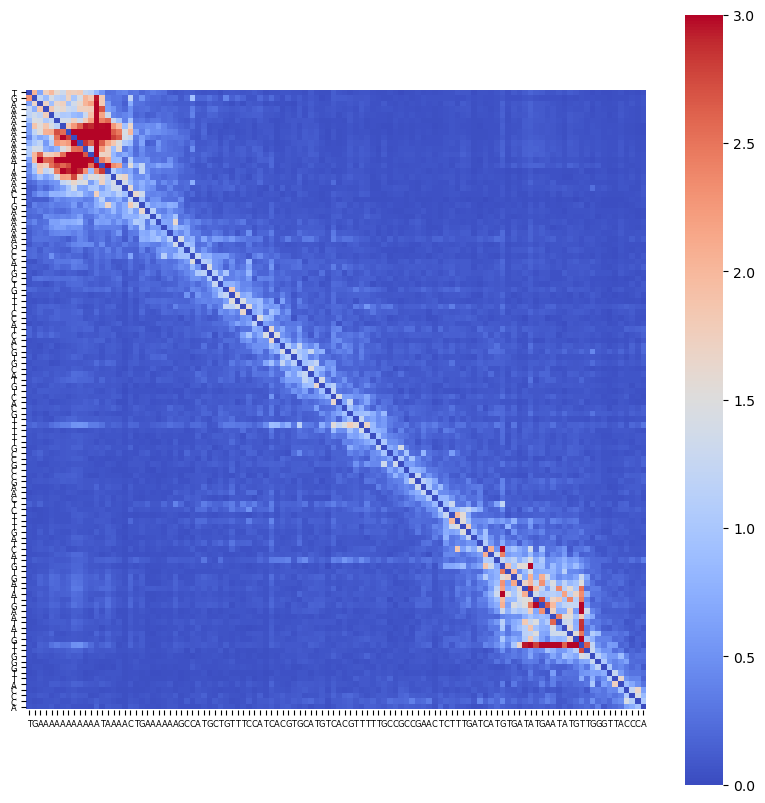

In [118]:
#SMT3 promoter in S cerevisiae
plot_map_with_seq(dep_map[690:800,690:800],  SMT3_five_prime_seq[690:800], vmax=3, tick_label_fontsize=6)